<a href="https://colab.research.google.com/github/zeinabmohamed/CIT690E-DeepLearning-Zeinab_Abdelmawla-191009/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**• Q1) In up to 3 sentences describe tilted convolution.** 

Convolutional neural networks (CNNs) have been successfully applied to many
tasks such as digit and object recognition. Using convolutional (tied) weights
significantly reduces the number of parameters that have to be learned, and also
allows translational invariance to be hard-coded into the architecture. In this paper, we consider the problem of learning invariances, rather than relying on hardcoding. We propose tiled convolution neural networks (Tiled CNNs), which use
a regular “tiled” pattern of tied weights that does not require that adjacent hidden
units share identical weights, but instead requires only that hidden units k steps
away from each other to have tied weights. By pooling over neighboring units,
this architecture is able to learn complex invariances (such as scale and rotational
invariance) beyond translational invariance. Further, it also enjoys much of CNNs’
advantage of having a relatively small number of learned parameters (such as ease
of learning and greater scalability). We provide an efficient learning algorithm for
Tiled CNNs based on Topographic ICA, and show that learning complex invariant
features allows us to achieve highly competitive results for both the NORB and
CIFAR-10 datasets.


*   List item
*   List item



##- Q2) Python-Pytorch: Using MNIST dataset, compare in terms of the train and test accuracies of two different ConvNet models (kernel width 5, 32 filters) at:
##• Stride of 1 and 2.
##• Calculate the total number of parameters for each case.

In [3]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


In [7]:
class CNN1(torch.nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [9]:
model1 = CNN1()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model1.cuda()

In [11]:
no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1


Epoch: 1/10, Train Loss: 0.31454209, Val Loss: 0.06272845, Val Accuracy: 0.98044444
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06272845

Epoch: 2/10, Train Loss: 0.10701306, Val Loss: 0.04279739, Val Accuracy: 0.98477778
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.04279739

Epoch: 3/10, Train Loss: 0.08169251, Val Loss: 0.03460512, Val Accuracy: 0.98800000
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03460512

Epoch: 4/10, Train Loss: 0.06557617, Val Loss: 0.02991306, Val Accuracy: 0.99011111
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02991306

Epoch: 5/10, Train Loss: 0.05738250, Val Loss: 0.02721206, Val Accuracy: 0.99088889
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02721206

Epoch: 6/10, Train Loss: 0.04951271, Val Loss: 0.02693702, Val Accuracy: 0.99111111
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02693702

Epoch: 7/

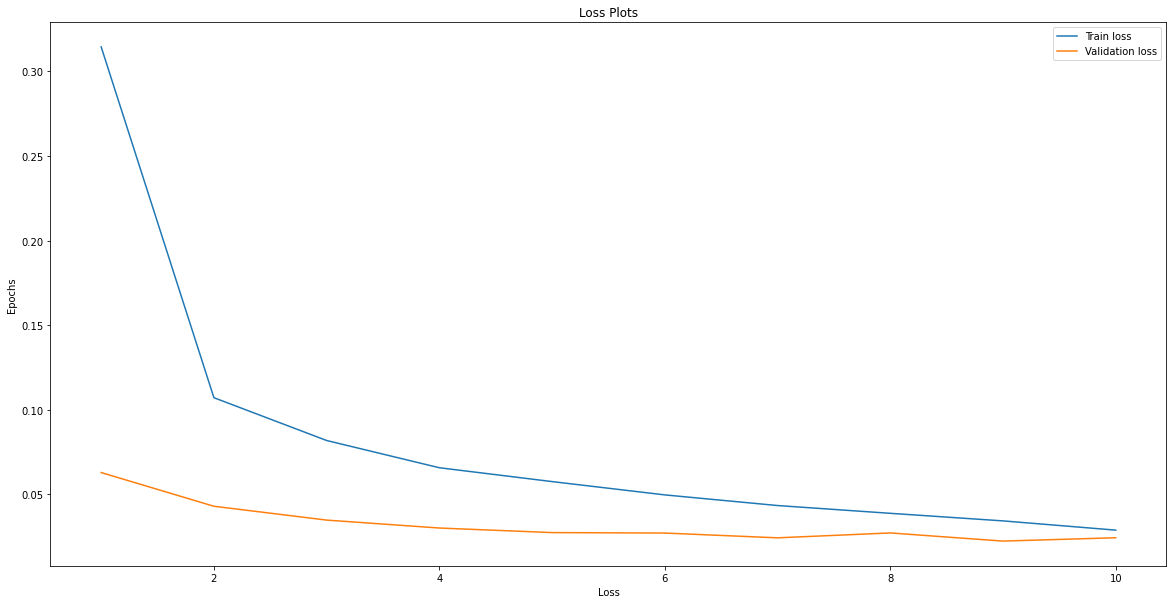

In [12]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model1.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model1(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model1.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model1(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model1.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [13]:
1# test model1
model1.load_state_dict(torch.load("model.dth"))
model1.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model1(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(mnist_testset)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.99400000


In [14]:
#Calculate the total number of parameters for model stride 1
from prettytable import PrettyTable

def count_parameters(model1):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model1.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model1)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  conv_1.weight  |    288     |
|   conv_1.bias   |     32     |
|  conv_2.weight  |   18432    |
|   conv_2.bias   |     64     |
| linear_1.weight |   401408   |
|  linear_1.bias  |    128     |
| linear_2.weight |    1280    |
|  linear_2.bias  |     10     |
+-----------------+------------+
Total Trainable Params: 421642


421642

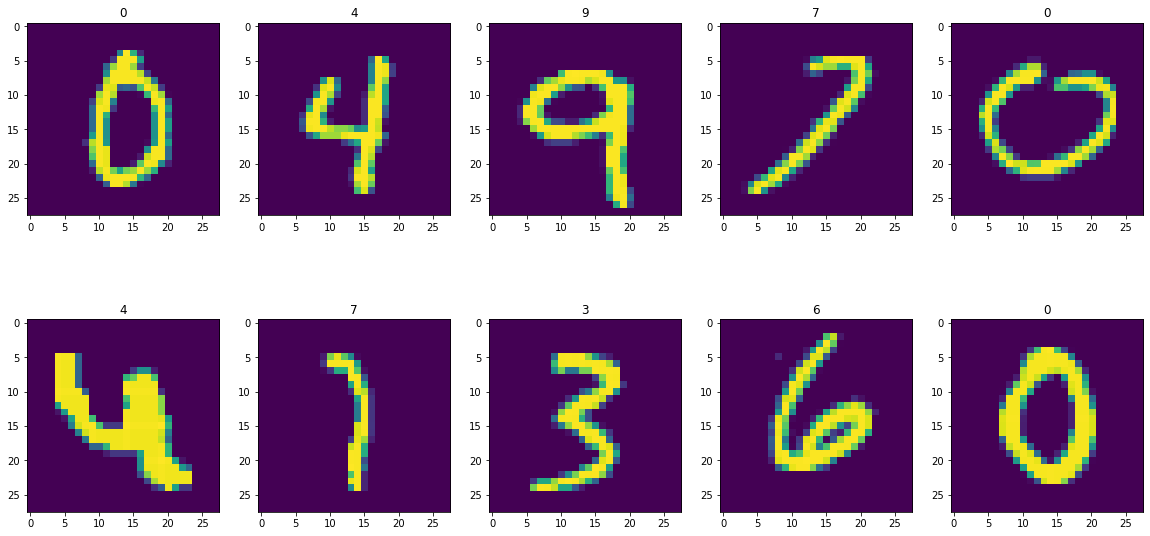

In [15]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):

    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img)
plt.show()

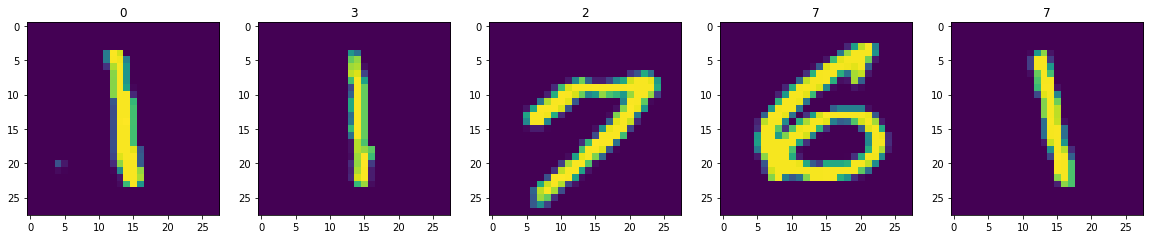

In [16]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):

    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img)
plt.show()

In [17]:
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=9)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=9)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [18]:
model2 = CNN2()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model2.cuda()

In [19]:
no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1


Epoch: 1/10, Train Loss: 0.65196976, Val Loss: 0.18328508, Val Accuracy: 0.94077778
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.18328508

Epoch: 2/10, Train Loss: 0.24829637, Val Loss: 0.11617820, Val Accuracy: 0.96244444
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.11617820

Epoch: 3/10, Train Loss: 0.18634435, Val Loss: 0.08877429, Val Accuracy: 0.97144444
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.08877429

Epoch: 4/10, Train Loss: 0.15508209, Val Loss: 0.07566613, Val Accuracy: 0.97422222
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.07566613

Epoch: 5/10, Train Loss: 0.13057111, Val Loss: 0.08225378, Val Accuracy: 0.97333333

Epoch: 6/10, Train Loss: 0.11704431, Val Loss: 0.06955591, Val Accuracy: 0.97755556
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.06955591

Epoch: 7/10, Train Loss: 0.10618790, Val Loss: 0.06257634, Val Accuracy: 0.97977778
Savin

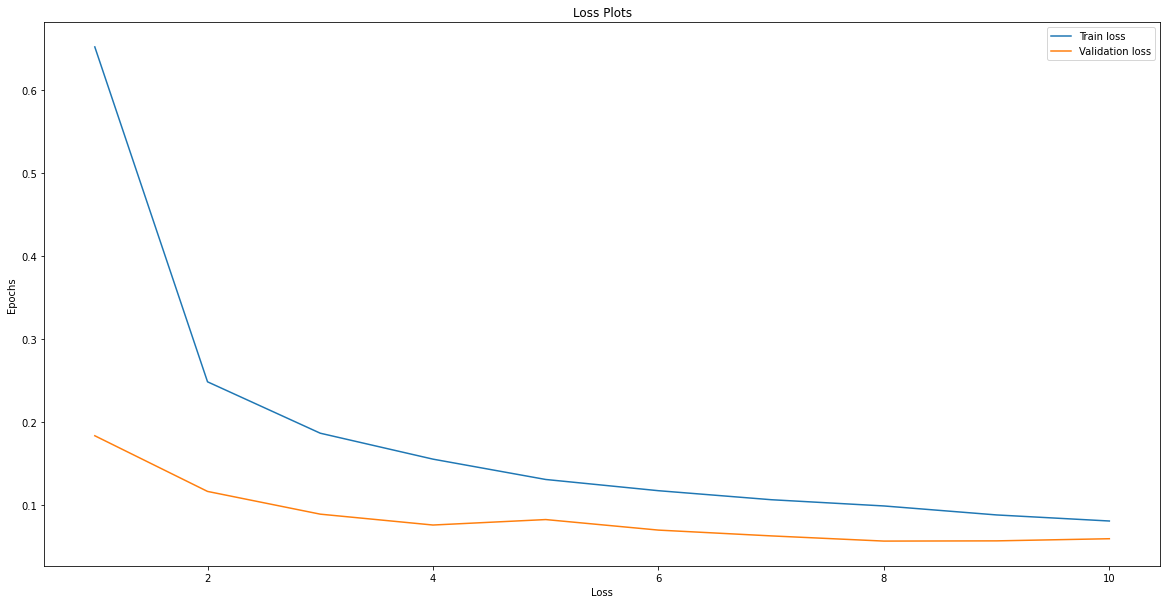

In [20]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model2.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model2(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model2.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model2(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model2.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [21]:
# test model
model2.load_state_dict(torch.load("model.dth"))
model2.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model2(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(mnist_testset)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.98200000


In [22]:
#Calculate the total number of parameters for model stride 2
from prettytable import PrettyTable

def count_parameters(model2):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model2.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model2)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  conv_1.weight  |    288     |
|   conv_1.bias   |     32     |
|  conv_2.weight  |   18432    |
|   conv_2.bias   |     64     |
| linear_1.weight |   401408   |
|  linear_1.bias  |    128     |
| linear_2.weight |    1280    |
|  linear_2.bias  |     10     |
+-----------------+------------+
Total Trainable Params: 421642


421642

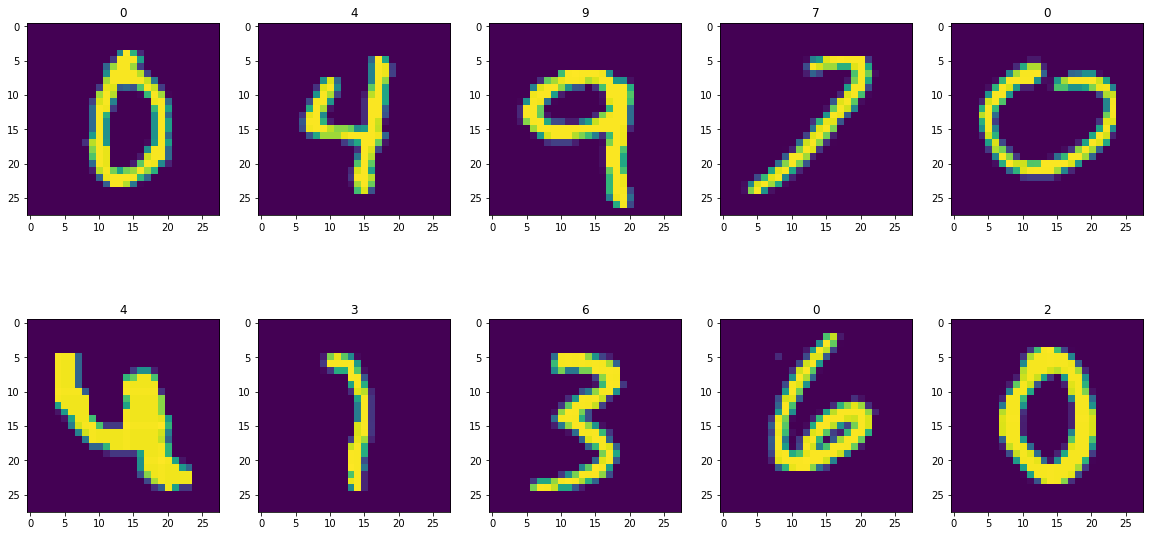

In [24]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):

    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img)
plt.show()

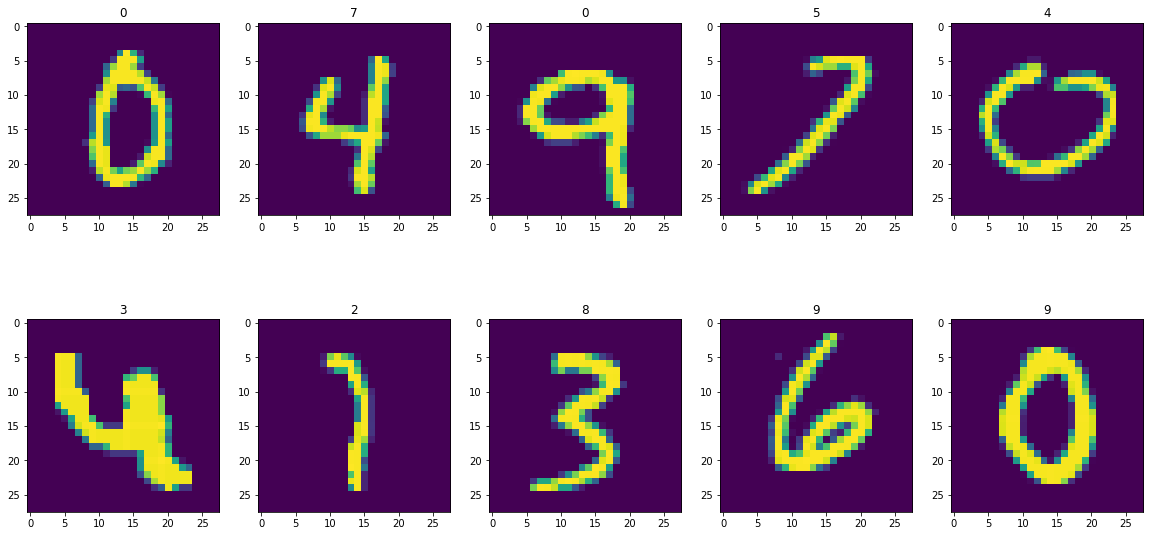

In [25]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):

    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img)
plt.show()

##**• Q3) From the previous question, plot sample successful and failure cases, and try to explain the effect of changing the Stride size on the results.**


Stride 1 has higher accurecy and it's make senace bucause stride 1 jump 1 step in Vertically and horizontally to collect more feature data. 
###- Stride 1 model 
**training time is 12m &&  Test accuracy 0.99400000**
###- Stride 2 model 
**training time is 10m &&  Test accuracy 0.98200000**

##**• Q4) [True or False] The softmax activation function is shift-invariant. Explain why you chosen your answer.**

True as softmax is just for normalization (e^e^x - e)'highlight higher than bias variances' but it dosen't affect the varincies properlaities .

https://datascience.stackexchange.com/a/66855